<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>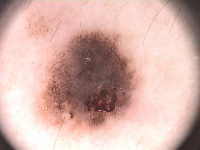</td><td>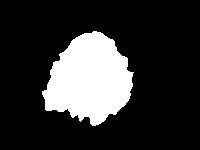</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=1bed4441-f81c-49c1-8a71-0648a2043281
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 104MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

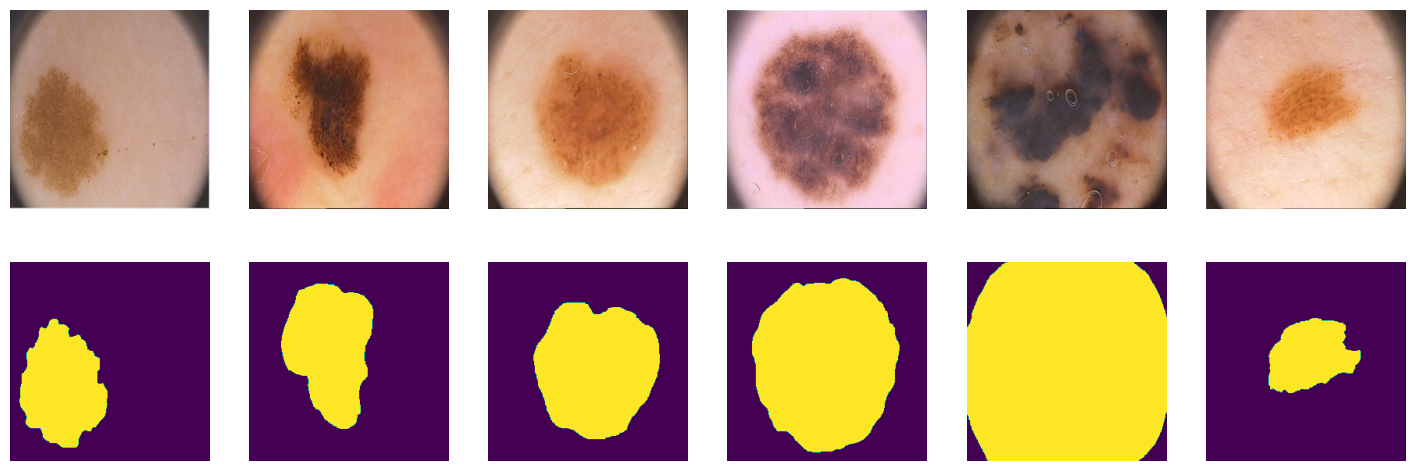

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum')
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
    prob = torch.sigmoid(y_pred)
    return -torch.sum(y_real * torch.log(prob) + (1 - y_real) * torch.log(1 - prob))

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 6.409115314483643
BCE loss честно посчитанный = 6.409114837646484
BCE loss from torch bce_torch = 6.409114837646484
BCE loss from torch with logits bce_torch = 6.409115314483643


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 10.203110694885254
BCE loss честно посчитанный = 10.203110694885254
BCE loss from torch bce_torch = 10.203110694885254
BCE loss from torch with logits bce_torch = 10.203110694885254


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.24MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.39MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-21-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

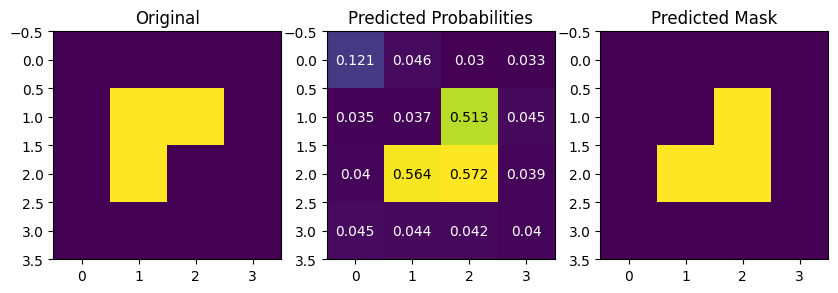

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

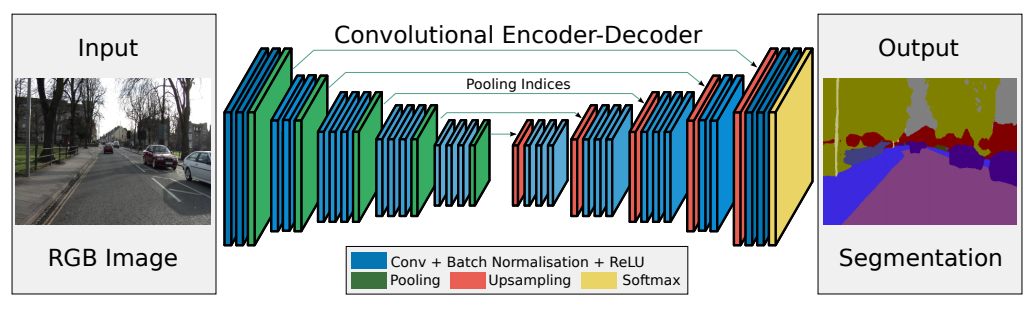

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
import torch.nn as nn


class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # No activation

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)
        return output


## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

    best_iou = -float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0

        for inputs, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            train_loss += loss.item()

            iou = iou_score(outputs, targets)
            train_iou += iou.mean().item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_dataloader):.4f}, IoU: {train_iou/len(train_dataloader):.4f}")

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, targets)
                val_loss += loss.item()

                iou = iou_score(outputs, targets)
                val_iou += iou.mean().item()

        print(f"Validation Loss: {val_loss/len(val_dataloader):.4f}, IoU: {val_iou/len(val_dataloader):.4f}")

        if val_iou / len(val_dataloader) > best_iou:
            best_iou = val_iou / len(val_dataloader)
            best_model = model.state_dict()

    print(f"Best IoU on Validation: {best_iou:.4f}")
    return best_model


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
model = SegNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_model = train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.7008, IoU: 0.2172


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6871, IoU: 0.0000


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20, Loss: 0.6475, IoU: 0.3749


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6841, IoU: 0.0000


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20, Loss: 0.5672, IoU: 0.5782


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6765, IoU: 0.0000


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20, Loss: 0.5023, IoU: 0.6681


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6645, IoU: 0.0000


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20, Loss: 0.4259, IoU: 0.7700


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6509, IoU: 0.0000


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20, Loss: 0.3961, IoU: 0.7461


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6416, IoU: 0.0000


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20, Loss: 0.3615, IoU: 0.7493


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6416, IoU: 0.0000


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20, Loss: 0.3356, IoU: 0.7676


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6354, IoU: 0.0225


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20, Loss: 0.3218, IoU: 0.7504


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.4953, IoU: 0.4083


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20, Loss: 0.2855, IoU: 0.7880


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.3611, IoU: 0.6283


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20, Loss: 0.2797, IoU: 0.7872


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.3178, IoU: 0.7072


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20, Loss: 0.2473, IoU: 0.8155


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.3025, IoU: 0.7248


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20, Loss: 0.2314, IoU: 0.8346


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.3023, IoU: 0.7065


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20, Loss: 0.2308, IoU: 0.8084


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.2253, IoU: 0.8069


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20, Loss: 0.2175, IoU: 0.8284


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.1993, IoU: 0.8399


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20, Loss: 0.1877, IoU: 0.8758


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.1913, IoU: 0.8564


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20, Loss: 0.1723, IoU: 0.8775


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.2427, IoU: 0.7986


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20, Loss: 0.2181, IoU: 0.8182


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.2151, IoU: 0.8238


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20, Loss: 0.1754, IoU: 0.8593


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.2130, IoU: 0.8121


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20, Loss: 0.1727, IoU: 0.8515


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.2014, IoU: 0.8284
Best IoU on Validation: 0.8564


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model_state, model, test_dataloader, device):
    model.load_state_dict(model_state)
    model.to(device)

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

    test_iou = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Testing", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            iou = iou_score(outputs, targets)
            test_iou += iou.mean().item()

    return test_iou / len(test_dataloader)

In [ ]:
iou = test(best_model, model, test_dataloader, 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'IoU: {iou}')


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

IoU: 0.7703911066055298


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    probs = torch.sigmoid(logits)
    predictions = (probs > threshold).int()

    tp = ((predictions == 1) & (labels == 1)).sum().item()
    fp = ((predictions == 1) & (labels == 0)).sum().item()
    fn = ((predictions == 0) & (labels == 1)).sum().item()
    eps = torch.exp(torch.tensor(-150.0))

    score = (2*tp+1e-10) / (2*tp + fn + fp +1e-10)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

0.6666666666722222

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    probs = torch.sigmoid(logits)



    intersection = (probs * labels).sum()
    union = probs.sum() + labels.sum()

    dice_coeff = (2.0 * intersection + 1e-10) / (union + 1e-10)

    return 1.0 - dice_coeff

Проверка на корректность:

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=bd16a470f207c959e7bfba0f51cac1dd8da689181e4d69707c9e14fe984c1a79
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ee6fca7d83423e642e007a31441e79a11b29aedc39379a54c1e1382136d803ef
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, gamma=2):
    probs = torch.sigmoid(y_pred)
    pt = probs * y_real + (1 - probs) * (1 - y_real)
    bce_loss = - (y_real * torch.log(probs) + (1 - y_real) * torch.log(1 - probs))
    loss = ((1 - pt) ** gamma) * bce_loss
    return loss.sum()

Проверка корректности функции:

In [ ]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0).item()

3.616123914718628

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').item()

3.616123676300049

In [ ]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),atol=1e-6)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

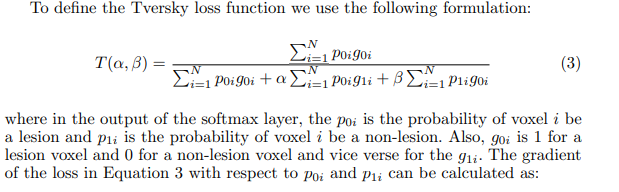

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, epsilon=1e-6):
    y_pred = torch.sigmoid(y_pred)

    p0i = y_pred
    p1i = 1 - y_pred

    g0i = y_true
    g1i = 1 - y_true

    intersection = (p0i * g0i).sum()
    fp = (p0i * g1i).sum()
    fn = (p1i * g0i).sum()

    tversky_index = intersection / (intersection + alpha * fp + beta * fn + epsilon)

    loss = 1 - tversky_index
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
# Обучение модели с Tversky loss
model_tversky = SegNet()
criterion = tversky_loss
optimizer = optim.Adam(model_tversky.parameters(), lr=1e-4)
best_model_tversky = train(model_tversky, train_dataloader, valid_dataloader, criterion=tversky_loss, optimizer=optimizer, epochs=20, device='cuda')

Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.9349, IoU: 0.2443


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0670, IoU: 0.0000


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20, Loss: 0.8031, IoU: 0.2756


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0504, IoU: 0.0046


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20, Loss: 0.6886, IoU: 0.3015


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0177, IoU: 0.2167


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20, Loss: 0.5685, IoU: 0.3378


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0253, IoU: 0.1952


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20, Loss: 0.4597, IoU: 0.3813


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0523, IoU: 0.1755


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20, Loss: 0.3434, IoU: 0.4382


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.0971, IoU: 0.1594


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20, Loss: 0.2562, IoU: 0.5011


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.1671, IoU: 0.1337


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20, Loss: 0.1750, IoU: 0.5774


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 1.1852, IoU: 0.1259


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20, Loss: 0.1107, IoU: 0.6223


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.7436, IoU: 0.2675


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20, Loss: 0.0283, IoU: 0.7162


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.1561, IoU: 0.6006


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20, Loss: -0.0217, IoU: 0.7347


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.1703, IoU: 0.6553


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20, Loss: -0.0691, IoU: 0.7472


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.2309, IoU: 0.7111


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20, Loss: -0.1178, IoU: 0.7809


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.3542, IoU: 0.7546


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20, Loss: -0.1523, IoU: 0.7829


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.1175, IoU: 0.6657


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20, Loss: -0.1808, IoU: 0.7652


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4783, IoU: 0.7248


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20, Loss: -0.2188, IoU: 0.7883


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4503, IoU: 0.7427


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20, Loss: -0.2444, IoU: 0.7882


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4625, IoU: 0.7577


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20, Loss: -0.2740, IoU: 0.8068


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4749, IoU: 0.7559


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20, Loss: -0.2840, IoU: 0.7802


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4777, IoU: 0.7685


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20, Loss: -0.3118, IoU: 0.7870


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: -0.4590, IoU: 0.7625
Best IoU on Validation: 0.7685


In [ ]:
# Обучение модели с Focal loss
model_focal = SegNet()
criterion = lambda outputs, targets: sigmoid_focal_loss(outputs, targets, alpha=-1, gamma=2, reduction='sum')
optimizer = optim.Adam(model_focal.parameters(), lr=1e-4)
best_model_focal = train(model_focal, train_dataloader, valid_dataloader, criterion=focal_loss, optimizer=optimizer, epochs=20, device='cuda')

Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20, Loss: 718550.5000, IoU: 0.0414


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 616357.4375, IoU: 0.0000


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20, Loss: 624631.5625, IoU: 0.0086


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 618062.6250, IoU: 0.0000


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20, Loss: 586367.9141, IoU: 0.0110


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 614791.0312, IoU: 0.0000


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20, Loss: 558855.1094, IoU: 0.1325


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 605967.0625, IoU: 0.0000


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20, Loss: 530206.0547, IoU: 0.3105


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 586447.3125, IoU: 0.0535


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20, Loss: 479111.1328, IoU: 0.3218


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 557259.3750, IoU: 0.3331


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20, Loss: 442050.1875, IoU: 0.3251


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 517409.8750, IoU: 0.3433


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20, Loss: 387038.5703, IoU: 0.3351


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 477552.4375, IoU: 0.3587


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20, Loss: 341685.4453, IoU: 0.3446


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 815325.8750, IoU: 0.3858


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20, Loss: 308217.5938, IoU: 0.3496


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 519504.0312, IoU: 0.3999


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20, Loss: 264043.6602, IoU: 0.3704


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 296179.1562, IoU: 0.3930


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20, Loss: 237592.7383, IoU: 0.3936


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 244324.6172, IoU: 0.3827


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20, Loss: 216727.3750, IoU: 0.3969


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 217193.3281, IoU: 0.3719


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20, Loss: 205214.2852, IoU: 0.4116


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 199902.9297, IoU: 0.3444


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20, Loss: 202410.2734, IoU: 0.4370


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 191920.4375, IoU: 0.3604


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20, Loss: 202916.8672, IoU: 0.4351


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 189794.7812, IoU: 0.3706


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20, Loss: 200417.7852, IoU: 0.4195


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 189425.0000, IoU: 0.3775


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20, Loss: 200128.6328, IoU: 0.4130


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 189393.4219, IoU: 0.4079


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20, Loss: 199456.4102, IoU: 0.4157


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 189547.6172, IoU: 0.4409


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20, Loss: 198801.5117, IoU: 0.4243


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 189518.9922, IoU: 0.4539
Best IoU on Validation: 0.4539


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

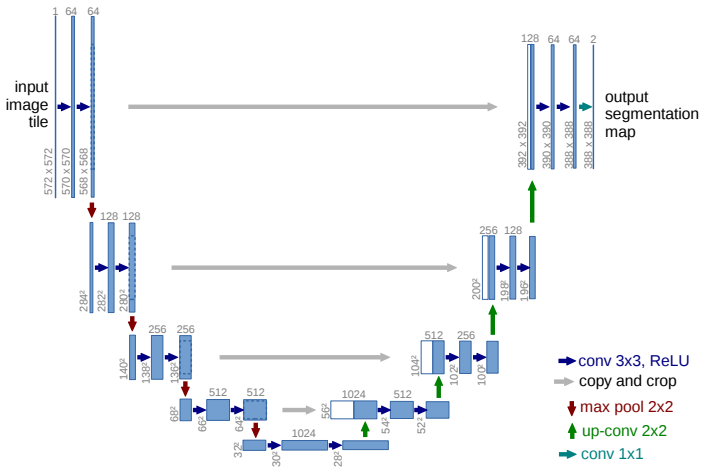

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.dec4 = self.upconv_block(1024, 512)
        self.dec3 = self.upconv_block(512 + 512, 256)
        self.dec2 = self.upconv_block(256 + 256, 128)
        self.dec1 = self.upconv_block(128 + 128, 64)

        self.conv_after_dec4 = nn.Conv2d(1024, 512, kernel_size=1)
        self.conv_after_dec3 = nn.Conv2d(768, 256, kernel_size=1)
        self.conv_after_dec2 = nn.Conv2d(384, 128, kernel_size=1)
        self.conv_after_dec1 = nn.Conv2d(192, 64, kernel_size=1)

        self.out = nn.Conv2d(64, n_class, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.dec4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv_after_dec4(dec4)

        dec3 = self.dec3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv_after_dec3(dec3)

        dec2 = self.dec2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv_after_dec2(dec2)

        dec1 = self.dec1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv_after_dec1(dec1)

        output = self.out(dec1)

        return output

In [79]:
torch.cuda.empty_cache()

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [80]:
unet_model_bce = UNet()
optimizer_unet_bce = optim.Adam(unet_model_bce.parameters(), lr=1e-4)
best_model_bce = train(unet_model_bce, train_dataloader, valid_dataloader,
                       criterion=nn.BCEWithLogitsLoss(), optimizer=optimizer_unet_bce,
                       epochs=10, device='cuda')


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 11118 has 14.74 GiB memory in use. Of the allocated memory 14.61 GiB is allocated by PyTorch, and 12.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

best_model_dice = train(unet_model, train_dataloader, valid_dataloader, criterion = dice_loss, epochs=10, device=device)
unet_model.load_state_dict(torch.load('checkpoint.pt'))
best_model_focal